In [ ]:
# Armchair edge Hamiltonian

He we check the method of constructing effective armchair Hamiltonian gives the same results as the more simple way of using a 2D Hamiltonian, but changing BZ. 

In [51]:
import sys
from hpc05 import HPC05Client
cluster = HPC05Client()

In [61]:
v = cluster[:]
lview = cluster.load_balanced_view()
len(v)

98

In [62]:
%%px --local
from types import SimpleNamespace
import tinyarray as ta
import numpy as np
import pickle
import kwant

s0 = ta.array([[1,0], [0,1]])
s1 = ta.array([[0,1], [1,0]])
s2 = ta.array([[0, -1j], [1j, 0]])
s3 = ta.array([[1,0], [0, -1]])

In [63]:
%%px --local
import Mod.MoS2_3bnd as H
c = H.c

In [64]:
import matplotlib.pyplot as plt

In [116]:
%%px --local
def ham_sc(k1, k2, p, c=c):
    """BdG Hamiltonian 
    d.o.f.: (orb, spin, ph)
    """
    h0 = np.array([ [2*c.t0*np.cos(k1)+c.e1-p.mu, 2j*c.t1*np.sin(k1), 2*c.t2*np.cos(k1)],
        [-2j*c.t1*np.sin(k1), 2*c.t11*np.cos(k1)+c.e2-p.mu, 2j*c.t12*np.sin(k1)],
        [2*c.t2*np.cos(k1), -2j*c.t12*np.sin(k1), 2*c.t22*np.cos(k1)+c.e2-p.mu] ])
    
    so = p.lam*np.kron(np.kron(np.array([[0, 0, 0], [0, 0, 1j], [0, -1j, 0]]), s3), s0)
    sc = p.delta*np.kron(np.kron(np.eye(3), s2), s2)
    zeeman = p.B*np.cos(p.theta)*np.kron(np.kron(np.eye(3), s1), s3) \
        + p.B*np.sin(p.theta)*np.kron(np.kron(np.eye(3), s2), s0)

    # intra cell contribution to KM term
    hkm_in =  2*p.bso*np.sin(k1)*np.kron(np.kron(np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]]), s3), s0)
    
    ham0 = np.kron(np.kron(h0, s0), s3) + so + sc + zeeman + hkm_in
    
    b11 = 4*c.t0*np.cos(0.5*k1)*np.cos(0.5*k2)
    b12 = 2*np.sin(0.5*k1)*(1j*c.t1*np.cos(0.5*k2)-np.sqrt(3)*c.t2*np.sin(0.5*k2))
    b13 = 2*np.cos(0.5*k1)*(1j*np.sqrt(3)*c.t1*np.sin(0.5*k2)-c.t2*np.cos(0.5*k2))
    b22 = (c.t11+3*c.t22)*np.cos(0.5*k1)*np.cos(0.5*k2)
    b23 = np.sin(0.5*k1)*(np.sqrt(3)*(c.t22-c.t11)*np.sin(0.5*k2)-4j*c.t12*np.cos(0.5*k2))
    b33 = (3*c.t11+c.t22)*np.cos(0.5*k1)*np.cos(0.5*k2)

    B = np.kron(np.kron(np.array([[b11, b12, b13],[np.conj(b12), b22, b23],
            [np.conj(b13), np.conj(b23), b33]]), s0), s3)  * np.exp(.5j*(k1+k2))
    
    hkm = -4*p.bso*np.sin(0.5*k1)*np.cos(0.5*k2)*np.kron(np.kron(
        np.array([[1, 0, 0], [0, 0, 0], [0, 0, 0]]), s3), s0)  * np.exp(.5j*(k1+k2))
        
    B = B + hkm
    
    return np.bmat([[ham0, np.conj(B.T)], [B, ham0]])

def spectrum(k1, k2, p):
    """Returns eigenvalues of the Hamiltonian
    """
    return np.linalg.eigvalsh(ham_sc(k1, k2, p))

def detA(k1, k2, p):
    """
    Returns the determinant of the off-diagonal block of chiral transformed BdG Hamiltonian
    (orb, spin, ph) d.o.f.
    """
    evals, evecs = np.linalg.eigh(np.kron(np.kron(np.kron(s0, np.eye(3)), s1), s2))
    det = np.linalg.det((evecs.conj().transpose() @ ham_sc(k1, k2, p) @ evecs)[:12, 12:])
    return det/np.abs(det)

def jump(p, k11, k12, k2, na = 300):
    """Returns determinants between 2 close points in momentum space such that the distance between the
    determinants is smaller than the desired ds.
    It does not return the final determinant(kperp2).
    
    Parameters:
    -----------
    k11, k12, k2 : float
        k12 > k11, close points in BZ.
    na: int
        Presumtive discretization on the BZ.
    """
    dets = []
    ds = 2.*np.pi/na
    
    det2 = detA(k12, k2, p)
    
    while k11 != k12:
        trial = k12
        det1 = detA(k11, k2, p)
        distance = H.dist(det1, det2)
        while distance > ds:
            trial = 0.5*(k11+trial)
            det_trial = detA(trial, k2, p)
            distance = H.dist(det1, det_trial)
            
        dets.append((np.real(det1), np.imag(det1)))
        k11 = trial
    return dets

def winding_adaptative(p, k2, na=300, **kwargs):
    """Adaptative computation of winding number.
    na : int
        Presumtive discretization on the BZ.
    k2 : float
        Momentum in parallel direction.
    """
    p.__dict__.update(kwargs)
    
    # Brillouin zone
    k1s = np.linspace(-np.pi, np.pi, na, endpoint=True)
    
    data = []
    
    init = k1s[0]
    for k1 in k1s[1:]:
        dets = jump(p, init, k1, k2, na=na)
        data.extend(dets)
        init = k1
        
    # adding the final point
    detFin = detA(k1s[-1], k2, p)
    data.append((np.real(detFin), np.imag(detFin)))
    
    data = np.asarray(data)
    x = data[:, 0]
    y = data[:, 1]
    
    # computing the invariant
    idx = np.argwhere(np.diff(np.sign(x)) != 0)
    return -0.5*np.sign(y[idx] * np.diff(x)[idx]).sum()

In [130]:
def scan_wind_ky(p, k2, mus, sqvd, na = 300):
    """Scan winding number at fixed ky when varying sqrt(V^2-D^2) and mu
    """
    vs = np.sqrt(sqvd**2+p.delta**2)
    V, M = np.meshgrid(vs, mus)
    proc = lview.map_async(lambda par: winding_adaptative(p, k2=k2, mu=par[1], B=par[0], na=na),
        zip(V.ravel(), M.ravel()))
    proc.wait_interactive(interval=2)
    return np.asarray(proc.get()).reshape(M.shape)

In [131]:
p = SimpleNamespace(B=0., theta=0., lam=.073, mu=0., bso=0.00035, delta = .8e-3)

In [ ]:
%%time

ky = 0
mus = np.linspace(1.704, 1.712, 100)
sqvd = np.linspace(0, 0.004, 100)

Z = scan_wind_ky(p, ky, mus, sqvd, na = 300)

file = 'wind_arm_'+'ky_'+str(ky)+'.p'
pickle.dump((Z, p, ky, mus, sqvd), open(file, 'wb'))

In [ ]:
%matplotlib inline
Z, p, beta, mus, sqvd = pickle.load(open(file, 'rb'))

fig = plt.figure(figsize=(5, 5))

plt.imshow(Z, extent = [sqvd.min()*1e3, sqvd.max()*1e3, mus.min(), mus.max()], origin='lower', aspect='auto', cmap='seismic')
plt.colorbar()
plt.xlabel('$\sqrt{V^2-\Delta^2}$ [meV]')
plt.ylabel('$\mu$ [eV]')

# crossings
beta = 0.5*ky
print(beta)
mu1, mu2 = H.crossings(p, beta)
print(mu1, mu2)

plt.plot(sqvd*1e3, mu1+sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu1-sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu2+sqvd, 'green', ls='dashed')
plt.plot(sqvd*1e3, mu2-sqvd, 'green', ls='dashed')

plt.hlines(y=mu1, xmin=sqvd.min()*1e3, xmax=sqvd.max()*1e3, linestyles='dashed', linewidth=1., color='g')
plt.hlines(y=mu2, xmin=sqvd.min()*1e3, xmax=sqvd.max()*1e3, linestyles='dashed', linewidth=1., color='g')

plt.ylim(mus.min(), mus.max())
# plt.savefig('wind_arm_ky'+str(ky)+'.png', bbox_inches='tight', dpi=200)
plt.show()

In [219]:
p = SimpleNamespace(B=0., theta=0., lam=.073, mu=0., bso=0.00035, delta = .8e-3)

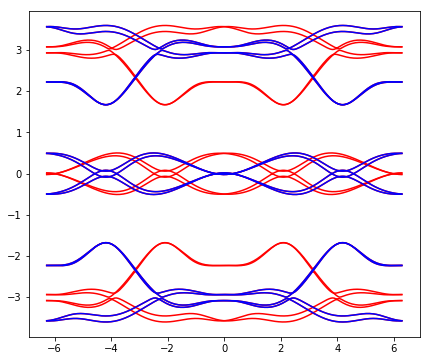

In [224]:
%matplotlib inline
k2 = 0.
k1s = np.linspace(-2*np.pi, 2*np.pi, 200)

spec = [spectrum(k1, k2, p) for k1 in k1s]
spec2 = [H.spectrum(.5*k1, .5*k2, p, sc=True) for k1 in k1s]

fig = plt.figure(figsize=(7, 6))
plt.plot(k1s, spec, 'r-')
plt.plot(k1s, spec2, 'b-')
plt.show()

## Density of states at armchair edge 

In [2]:
%%px --local
def make_lead(p, c=H.c, keep=None):
    '''Tight-binding infinite system. Works for only for armchair.
    keep options:
        None : infinite 2d system
        int : keep translational symmetry in that direction
        (while one is assign a momentum index)
    d.o.f.: (ph, spin, orbital)
    '''
    def onsite(site):
        return p.B*np.cos(p.theta)*np.kron(s3, np.kron(s1, np.eye(3))) \
        + p.B*np.sin(p.theta)*np.kron(s0, np.kron(s2, np.eye(3)))  \
        + p.delta*np.kron(s2, np.kron(s2, np.eye(3))) \
        + p.lam*np.kron(s0, np.kron(s3, np.array([[0, 0, 0], [0, 0, 1j], [0, -1j, 0]]))) \
        + np.kron(s3, np.kron(s0, ta.array([[c.e1-p.mu, 0, 0], [0, c.e2-p.mu, 0], [0, 0, c.e2-p.mu]])))
                         
    def hopR1(site1, site2):
        return -1j*p.bso*np.kron(s0, np.kron(s3, ta.array([[1., 0., 0.], [0., 0., 0.], [0., 0., 0.]]))) \
        + np.kron(s3, np.kron(s0, ta.array([[c.t0, c.t1, c.t2], [-c.t1, c.t11, c.t12], [c.t2, -c.t12, c.t22]])))

    def hopR2(site1, site2):
        return 1j*p.bso*np.kron(s0, np.kron(s3, ta.array([[1., 0., 0.], [0., 0., 0.], [0., 0., 0.]]))) \
        + np.kron(s3,
            np.kron(s0,ta.array([[c.t0, 0.5*(c.t1-np.sqrt(3)*c.t2), -0.5*(np.sqrt(3)*c.t1+c.t2)],
            [-0.5*(c.t1+np.sqrt(3)*c.t2), 0.25*(c.t11+3*c.t22), 0.25*np.sqrt(3)*(c.t22-c.t11)-c.t12],
            [0.5*(np.sqrt(3)*c.t1-c.t2), 0.25*np.sqrt(3)*(c.t22-c.t11)+c.t12, 0.25*(3*c.t11+c.t22)]])))
                      
    def hopR6(site1, site2):        
        return 1j*p.bso*np.kron(s0, np.kron(s3, ta.array([[1., 0., 0.], [0., 0., 0.], [0., 0., 0.]]))) \
        + np.kron(s3,
            np.kron(s0,ta.array([[c.t0, 0.5*(c.t1+np.sqrt(3)*c.t2), 0.5*(np.sqrt(3)*c.t1-c.t2)],
            [0.5*(-c.t1+np.sqrt(3)*c.t2), 0.25*(c.t11+3*c.t22), 0.25*np.sqrt(3)*(c.t11-c.t22)-c.t12],
            [0.5*(-np.sqrt(3)*c.t1-c.t2), 0.25*np.sqrt(3)*(c.t11-c.t22)+c.t12, 0.25*(3*c.t11+c.t22)]])))
        
    lat = kwant.lattice.triangular()
#     vecs = np.array([(1, 0), (0.5, 0.5*np.sqrt(3))])
#     lat = kwant.lattice.general(prim_vecs=vecs)

    sys = kwant.Builder(kwant.TranslationalSymmetry((1, 0), (0, np.sqrt(3))))
    sys[lat.shape(lambda pos: True, (0, 0))] = onsite
    
    sys[kwant.builder.HoppingKind((1, 0), lat, lat)] = hopR1
    sys[kwant.builder.HoppingKind((0, 1), lat, lat)] = hopR6
    sys[kwant.builder.HoppingKind((1, -1), lat, lat)] = hopR2
    return kwant.wraparound.wraparound(sys, keep=keep)

ERROR:root:Cell magic `%%px` not found.


In [ ]:
%%px --local
def density(p, kpar, erg, n, eta = 1e-2):
    sys = make_lead(p, keep=0).finalized()
    h, t = sys.cell_hamiltonian(args=[kpar]), sys.inter_cell_hopping(args=[kpar])
    
    invG0 = (erg + 1j*eta)*np.eye(h.shape[0]) - h
    G = np.linalg.inv(invG0)
    for j in range(n):
        G = np.linalg.inv(invG0 - t @ G @ t.T.conj())
    return -1/np.pi*np.imag(np.trace(G))

In [ ]:
def density(p, kpar, erg, eta = 1e-5):
    sys = make_lead(p, keep=0).finalized()
    h, t = sys.cell_hamiltonian(args=[kpar]), sys.inter_cell_hopping(args=[kpar])
    
    one = np.eye(len(h))
    zer = np.zeros_like(h)
    
    A = np.bmat([[-t.conj().T, zer], [zer, one]])
    B = np.bmat([[h-(erg+1j*eta)*np.eye(len(h)), t], [one, zer]])    
    evals, evecs = scipy.linalg.eig(A, B)
    
    idx = np.argsort(np.abs(evals))
    evecs = (evecs[:, idx])[:, :len(evecs)//2]

    U, lamU = evecs[:len(evecs)//2,:], evecs[len(evecs)//2:,:]
    G = np.linalg.solve(U.T @ t.conj(), lamU.T).T
    return -1/np.pi*np.imag(np.trace(G))

In [ ]:
def edge_ldos(p, ks, ergs, n=20, eta=1e-2):    
    K, E = np.meshgrid(ks, ergs)
    
    proc = lview.map_async(lambda par: density(p, kpar=par[0], erg=par[1], n=n, eta=eta), 
            zip(K.ravel(), E.ravel()))
    proc.wait_interactive(interval=2)
    return np.asarray(proc.get()).reshape(K.shape)

In [ ]:
def spatial_resolved_ldos(p, kpar, erg, n = 1000, eta = 5*1e-6):
    sys = make_lead(p, keep=0).finalized()
    h, t = sys.cell_hamiltonian(args=[kpar]), sys.inter_cell_hopping(args=[kpar])

    one = np.eye(len(h))
    zer = np.zeros_like(h)
    
    A = np.bmat([[-t.conj().T, zer], [zer, one]])
    B = np.bmat([[h-(erg+1j*eta)*np.eye(len(h)), t], [one, zer]])
    evals, evecs = scipy.linalg.eig(A, B)

    # select half of the propagating modes and the decaying ones
    # these have the smallest eigenvalues
    idx = np.argsort(np.abs(evals))
    evecs = (evecs[:, idx])[:, :len(evecs)//2]    

    
    U, lamU = evecs[:len(evecs)//2,:], evecs[len(evecs)//2:,:]
    
    SR = scipy.linalg.solve(U.T, lamU.T).T
    SL = scipy.linalg.solve(U.T @ t.conj(), lamU.T @ t.T).T

    rho = np.zeros(n)
    # surface green function
    G0 = scipy.linalg.solve(U.T @ t.conj(), lamU.T).T
    
    G = np.zeros_like(G0)
    G[:] = G0

    # density at site j
    rho[0] = -1/np.pi*np.imag(np.trace(G0))
    for j in range(1, n):
        G = G0 + SL @ G @ SR
        rho[j] = -1/np.pi*np.imag(np.trace(G))
    return rho

In [ ]:
ks = np.linspace(-0.5, 0.5, 100)
ergs = np.linspace(0, 0.02 * p.delta, 100)

# ergs = np.linspace(0, 3.5, 80)

rho = edge_ldos(p, ks, ergs, n = 50000, eta = 5*1e-6)

In [ ]:
file = 'ldos_arm_mu'+str(p.mu)+'_Ez'+str(p.B)+'.p'
pickle.dump((p, ks, ergs, Z), open(file, 'wb'))

In [ ]:
p, ks, ergs, rho = pickle.load(open(file, 'rb'))

In [ ]:
%matplotlib notebook
fig = plt.figure(figsize=(5, 3.5))
plt.imshow(rho, extent = [ks.min(), ks.max(),  ergs.min()/p.delta, ergs.max()/p.delta],
    origin='lower', aspect='auto', cmap='viridis')
plt.colorbar()

more_ks = np.linspace(ks.min(), ks.max(), 301)
w = np.asarray([0.5*np.abs(H.winding(p, .5*k))*ergs.max()/p.delta*0.98 for k in more_ks])
# w = np.asarray([np.abs(H.winding(p, .5*k)) for k in more_ks])

plt.plot(more_ks, w, 'r-', label='scaled top. inv. $|W|$', alpha=0.8)

plt.title('$E_Z='+str(np.round(p.B*1e3, 3)) +'$ meV; $\mu='+str(p.mu)+'$ eV')
plt.xlabel('$k_\parallel$')
plt.ylabel('$E/\Delta$')
plt.legend(loc=1)
plt.locator_params(nbins=5)
plt.show()